# Model_v0

Import des librairies

In [2]:
import numpy as np
import time
from datetime import datetime

Chargement des données

In [3]:
path = "/Users/gauthier/PO/inputs/group5min_dtrain4h_dpred1h_window10min"

input_type = path[path.rfind('/')+1:]

X_train, y_train = np.load(path+"/X_train.npy", allow_pickle=True), np.load(path+"/y_train.npy", allow_pickle=True)

X_val, y_val = np.load(path+"/X_val.npy", allow_pickle=True), np.load(path+"/y_val.npy", allow_pickle=True)

X_test, y_test = np.load(path+"/X_test.npy", allow_pickle=True), np.load(path+"/y_test.npy", allow_pickle=True)

Données d'architecture du LSTM

In [3]:
nb_inputs = X_train.shape[0]
nb_steps = X_train.shape[1]
nb_features = X_train.shape[2]

nb_inputs

40070

## Keras

In [4]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import keras
import keras.backend as K
import tensorflow as tf

from livelossplot import PlotLossesKeras

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


Metric to evaluate model

In [5]:
def count_by_row(t):
    y, idx, count = tf.unique_with_counts(t)
    return K.sum(count-1)

def metric_top_10(y_true, y_pred):
    _, ind_pred = tf.nn.top_k(y_pred, k=10, sorted=True, name=None)
    _, ind_true = tf.nn.top_k(y_true, k=10, sorted=True, name=None)

    count = tf.map_fn(count_by_row, tf.concat([ind_pred, ind_true], 1))
    return K.mean(count)
    # return tf.round(tf.reduce_mean(count), 3)

Parameters for the model

In [6]:
nb_steps = X_train.shape[1]
nb_features = X_train.shape[2]
nb_hidden_units = 300
batch_size = 256

nb_epoch = 10

out_shape = y_train.shape[1]

In [7]:
start=time.time()


model = Sequential()

model.add(LSTM(nb_hidden_units, activation='relu', input_shape=(nb_steps, nb_features)))
model.add(Dense(out_shape))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy', metric_top_10])

#checkpointer = ModelCheckpoint(filepath='weights/input_{}_hidden_{}_batch_{}_{}'.format(input_type, nb_hidden_units, batch_size, datetime.now()), verbose=1, save_best_only=True)
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs/input_{}_hidden_{}_batch_{}_{}'.format(input_type, nb_hidden_units, batch_size, datetime.now()),
#                                                      histogram_freq=1, update_freq='epoch')
# Load pre trained weights
model.load_weights('/Users/gauthier/PO/weights/input_group5min_dtrain4h_dpred1h_window10min_hidden_300_batch_256_1')

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=nb_epoch, verbose=1)
#          callbacks=[checkpointer,  tensorboard_callback])

print("\n")
print("Time : {:.2f} s".format(time.time()-start))

Train on 40070 samples, validate on 4453 samples
Epoch 1/10
29696/40070 [=====================>........] - ETA: 44s - loss: 7.5041 - accuracy: 0.7351 - metric_top_10: 6.0000

KeyboardInterrupt: 

Tensorboard

In [32]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6007 (pid 38443), started 2:17:06 ago. (Use '!kill 38443' to kill it.)

In [ ]:
model.summary()

Validate on test set

In [61]:
loss, acc, top_10 = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

print("Results on test set:\n"
      "\n"
      "Loss : {:.3f}\n"
      "Accuracy : {:.3f}\n"
      "Top 10 : {}".format(loss, acc, top_10))

4948/4948 [==============================] - 6s 1ms/step



In [66]:
print("Results on test set:\n"
      "\n"
      "Loss : {:.3f}\n"
      "Accuracy : {:.3f}\n"
      "Top 10 : {}".format(loss, acc, top_10))

Results on test set:
Loss : 7.633
Accuracy : 0.713
Top 10 : 6.0


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 281)               84581     
Total params: 805,781
Trainable params: 805,781
Non-trainable params: 0
_________________________________________________________________


In [25]:
import matplotlib.pyplot as plt

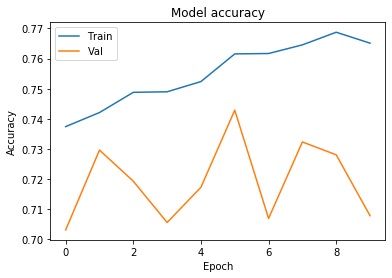

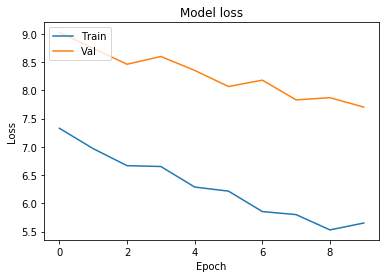

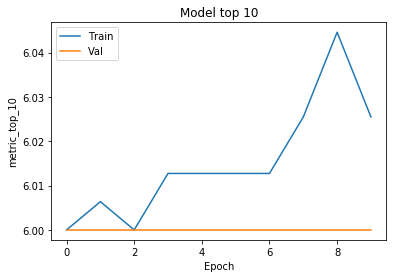

In [67]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation top10 values
plt.plot(history.history['metric_top_10'])
plt.plot(history.history['val_metric_top_10'])
plt.title('Model top 10')
plt.ylabel('metric_top_10')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [48]:
y_pred_test = model.predict(X_test)

In [58]:
score, acc, top_10 = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

4948/4948 [==============================] - 6s 1ms/step


In [57]:
acc

[7.632655900047013, 0.7126111388206482, 6.0]

In [50]:
keras.metrics.accuracy(y_test, y_pred_test)

<tf.Tensor: id=65024, shape=(4948, 281), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>